In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import DataLoader, ConcatDataset
from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
from tqdm.notebook import tqdm

sns.set_theme()

In [3]:
from nircoloring.dataset.downloader import SerengetiMetaDataSource
from nircoloring.evaluation.config import *

In [4]:
meta_data_source = SerengetiMetaDataSource()


def load_labels():
    annotations = meta_data_source.load_annotations()
    return annotations.groupby("image_id")["category_id"].unique()


def load_images():
    images = meta_data_source.load_images()
    images["base_file_name"] = images["file_name"].apply(lambda filename: PosixPath(filename).stem).str.lower()
    return images[["id", "base_file_name"]].set_index("base_file_name")


images = load_images()
labels = load_labels()

In [5]:
categories = meta_data_source.load_categories()

In [6]:
def load_label_map(entries):
    matched_images = images[images.index.isin(set(entries))]
    return matched_images.reset_index().merge(labels, left_on="id", right_on="image_id", how="left").set_index(
        "base_file_name")["category_id"]

In [7]:
filenames = serengeti_night_large_nir_train.image_filenames + serengeti_night_large_nir_test.image_filenames + serengeti_night_large_nir_val.image_filenames

filenames = pd.Series(filenames).apply(lambda filename: filename.stem).str.lower()
categories_of_dataset = load_label_map(filenames)

In [8]:
category_occurrences = {}

for category_set in categories_of_dataset:
    for category in category_set:
        if category not in category_occurrences.keys():
            category_occurrences[category] = 0
        category_occurrences[category] += 1

In [9]:
TOP_INDICES = set(category_occurrences.keys())

In [10]:
transformation_map = {
    index: i
    for i, index in enumerate(TOP_INDICES)
}


def transform_indices(indices):
    new_indices = []

    for index in indices:
        if index in transformation_map.keys():
            new_indices.append(transformation_map[index])

    return np.array(new_indices)


In [11]:
from torch.utils.data.dataset import T_co
from torch.utils.data import Dataset


def combine_and_filter(filenames, images):
    data = {"filename": filenames, "image": images}
    df = pd.DataFrame(data)
    df = df.merge(load_label_map(filenames), how="left", left_on="filename", right_index=True)
    df["category_id"] = df["category_id"].apply(transform_indices)
    df = df[df["category_id"].apply(lambda categories: len(categories) == 1)]
    df["category_id"] = df["category_id"].apply(lambda categories: categories[0])
    df = df.reset_index()
    return df


class SerengetiDataset(Dataset):
    def __init__(self, result: Result, transform, file_name_corrector=None) -> None:
        self.transform = transform

        filenames = pd.Series(result.image_filenames).apply(lambda filename: filename.stem).str.lower()
        if file_name_corrector is not None:
            filenames = filenames.apply(file_name_corrector)

        images = result.load_images()

        self.df = combine_and_filter(filenames, images)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index) -> T_co:
        row = self.df.iloc[index]

        img = row["image"]
        img = self.transform(img.copy())
        
        return {
            'image': img,
            'label': row["category_id"]
        }

In [12]:
train_transformations = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

validation_transformations = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


train_dataset_rgb = SerengetiDataset(
    transform=train_transformations,
    result=serengeti_night_large_rgb_train
)
train_dataset_nir = SerengetiDataset(
    transform=train_transformations,
    result=serengeti_night_large_nir_train
)

val_dataset_rgb = SerengetiDataset(
    transform=validation_transformations,
    result=serengeti_night_large_rgb_val
)
val_dataset_nir = SerengetiDataset(
    transform=validation_transformations,
    result=serengeti_night_large_nir_val
)

In [13]:
train_dataset_cycle_gan = SerengetiDataset(
    transform=train_transformations,
    result=cycle_gan_serengeti_night_large_train,
    file_name_corrector=lambda f: f.removesuffix("_fake")
)
val_dataset_cycle_gan = SerengetiDataset(
    transform=train_transformations,
    result=cycle_gan_serengeti_night_large_val,
    file_name_corrector=lambda f: f.removesuffix("_fake")
)

In [14]:
train_dataset_iis_cycle_gan = SerengetiDataset(
    transform=train_transformations,
    result=iis_cycle_gan_serengeti_night_large_train,
    file_name_corrector=lambda f: f.removesuffix("_fake")
)
val_dataset_iis_cycle_gan = SerengetiDataset(
    transform=train_transformations,
    result=iis_cycle_gan_serengeti_night_large_val,
    file_name_corrector=lambda f: f.removesuffix("_fake")
)

In [15]:
train_dataset_ihfs = SerengetiDataset(
    transform=train_transformations,
    result=ihfs_serengeti_night_large_train,
)
val_dataset_ihfs = SerengetiDataset(
    transform=train_transformations,
    result=ihfs_serengeti_night_large_val,
)

In [16]:
train_dataset_iis = SerengetiDataset(
    transform=train_transformations,
    result=iis_serengeti_night_large_train,
)
val_dataset_iis = SerengetiDataset(
    transform=train_transformations,
    result=iis_serengeti_night_large_val,
)

In [17]:
train_dataset = ConcatDataset([train_dataset_nir, train_dataset_rgb])
val_dataset = ConcatDataset([val_dataset_nir, val_dataset_rgb])

In [18]:
def train_one_epoch(model: torch.nn.Module, dataloader: DataLoader, optimizer: torch.optim.Optimizer,
                    criterion: torch.nn.Module,
                    device):
    model.train()
    counter = 0
    train_running_loss = 0.0
    acc_running = 0.0
    for i, data in enumerate(dataloader):
        counter += 1
        data, target, = data['image'].to(device), data['label'].to(device)
        optimizer.zero_grad()

        outputs = model(data)
        loss = criterion(outputs, target)

        train_running_loss += loss.item()

        loss.backward()
        optimizer.step()

        acc_running += accuracy(outputs, target).item()

    train_loss = train_running_loss / counter
    acc = acc_running / counter
    return train_loss, acc

In [19]:
def validate(model: torch.nn.Module, dataloader: DataLoader, criterion: torch.nn.Module, device):
    model.eval()
    counter = 0
    val_running_loss = 0.0
    acc_running = 0.0

    with torch.no_grad():
        for i, data in enumerate(dataloader):
            counter += 1
            data, target = data['image'].to(device), data['label'].to(device)

            outputs = model(data)
            loss = criterion(outputs, target)

            acc_running += accuracy(outputs, target).item()
            val_running_loss += loss.item()

        val_loss = val_running_loss / counter
        acc = acc_running / counter

        return val_loss, acc

In [20]:
def plot(train_loss, val_loss, train_acc, val_acc):
    fig, axs = plt.subplots(1, 2)
    axs[0].plot(train_loss, label='train loss')
    axs[0].plot(val_loss, label='validation loss')
    axs[1].plot(train_acc, label='train accuracy')
    axs[1].plot(val_acc, label='validation accuracy')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    plt.show()


def fit(model, epochs, optimizer, criterion, train_loader, val_loader, plot_freq=20):
    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []

    best_val_loss = 1e10
    best_model = model.state_dict()

    for epoch in tqdm(range(epochs), "Processing epochs"):
        train_epoch_loss, train_acc_epoch = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_epoch_loss, val_acc_epoch = validate(model, val_loader, criterion, device)

        train_loss.append(train_epoch_loss)
        train_acc.append(train_acc_epoch)

        val_loss.append(val_epoch_loss)
        val_acc.append(val_acc_epoch)

        print(f"Train Loss: {train_epoch_loss:.4f}, Acc: {train_acc_epoch}\n")
        print(f"Val Loss: {val_epoch_loss:.4f}, Acc: {val_acc_epoch}\n")

        if val_epoch_loss <= best_val_loss:
            best_val_loss = val_epoch_loss
            best_model = copy.deepcopy(model.state_dict())

        if epoch % plot_freq == 0 and epoch != 0:
            plot(train_loss, val_loss, train_acc, val_acc)

    plot(train_loss, val_loss, train_acc, val_acc)
    model.load_state_dict(best_model)
    return model, best_val_loss

In [21]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
torch.cuda.get_device_name(device)

'Quadro RTX 6000'

In [22]:
def accuracy(outputs, target: torch.Tensor):
    softmax = torch.log_softmax(outputs, dim=1)
    _, pred = torch.max(softmax, dim=1)
    
    correct_pred = (pred == target).float()
    return correct_pred.sum() / len(correct_pred)

In [23]:
def train_resnet(train_dataset, val_dataset, lr):
    torch.random.manual_seed(0)
    net = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

    net.fc = nn.Sequential(
        nn.Linear(in_features=net.fc.in_features, out_features=len(TOP_INDICES)),
    )
    net.to(device)

    epochs = 100
    batch_size = 128
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False
    )

    return fit(net, epochs, optimizer, criterion, train_loader, val_loader)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /home/ayk/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 147MB/s] 


Processing epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Train Loss: 2.8451, Acc: 0.30501302145421505

Val Loss: 2.4444, Acc: 0.3557477742433548
Train Loss: 1.8329, Acc: 0.50146484375

Val Loss: 1.9423, Acc: 0.4963727742433548
Train Loss: 1.3472, Acc: 0.6547037772834301

Val Loss: 1.3999, Acc: 0.6361607164144516
Train Loss: 1.0317, Acc: 0.73095703125

Val Loss: 1.2432, Acc: 0.67578125
Train Loss: 0.7622, Acc: 0.79736328125

Val Loss: 1.1793, Acc: 0.6810825914144516
Train Loss: 0.5812, Acc: 0.84912109375

Val Loss: 1.2857, Acc: 0.6509486734867096
Train Loss: 0.4290, Acc: 0.88916015625

Val Loss: 1.1347, Acc: 0.696428582072258
Train Loss: 0.3336, Acc: 0.920247396454215

Val Loss: 1.1755, Acc: 0.7045200914144516
Train Loss: 0.2660, Acc: 0.932210287079215

Val Loss: 1.0182, Acc: 0.7340959906578064
Train Loss: 0.1864, Acc: 0.9557291679084301

Val Loss: 1.0555, Acc: 0.7329799234867096
Train Loss: 0.1307, Acc: 0.9747721366584301

Val Loss: 0.9545, Acc: 0.749162957072258
Train Loss: 0.0853, Acc: 0.9873046875

Val Loss: 0.9072, Acc: 0.774832591414451

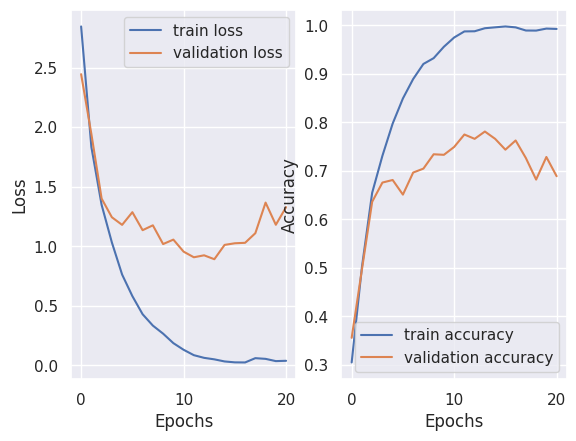

Train Loss: 0.0212, Acc: 0.996337890625

Val Loss: 1.1236, Acc: 0.7430245578289032
Train Loss: 0.0294, Acc: 0.9923502616584301

Val Loss: 1.0899, Acc: 0.7516741156578064
Train Loss: 0.0558, Acc: 0.9855143241584301

Val Loss: 1.2472, Acc: 0.7154017984867096
Train Loss: 0.0555, Acc: 0.9874674491584301

Val Loss: 1.1864, Acc: 0.7229352742433548
Train Loss: 0.0383, Acc: 0.989339193329215

Val Loss: 1.1631, Acc: 0.7290736734867096
Train Loss: 0.0369, Acc: 0.99072265625

Val Loss: 1.0220, Acc: 0.7661830484867096
Train Loss: 0.0281, Acc: 0.9940592460334301

Val Loss: 1.2408, Acc: 0.7215401828289032
Train Loss: 0.0306, Acc: 0.991780599579215

Val Loss: 1.1921, Acc: 0.7343750149011612
Train Loss: 0.0512, Acc: 0.985432943329215

Val Loss: 1.1509, Acc: 0.7578125149011612
Train Loss: 0.0577, Acc: 0.985432943329215

Val Loss: 1.1935, Acc: 0.716796875
Train Loss: 0.0606, Acc: 0.98583984375

Val Loss: 1.3324, Acc: 0.7134486734867096
Train Loss: 0.0840, Acc: 0.9777018241584301

Val Loss: 1.2420, Acc: 

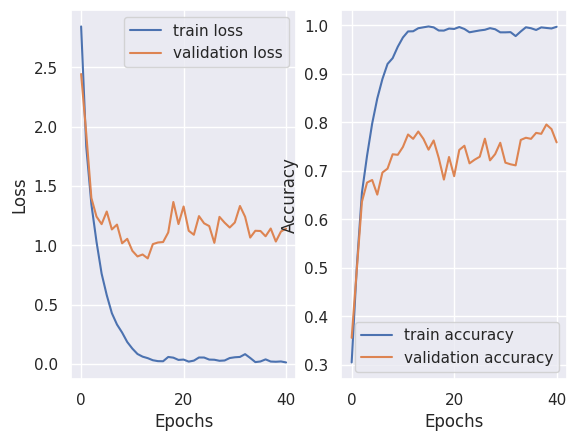

Train Loss: 0.0122, Acc: 0.996663412079215

Val Loss: 1.0344, Acc: 0.8080357164144516
Train Loss: 0.0156, Acc: 0.9957682304084301

Val Loss: 1.0060, Acc: 0.7912946492433548
Train Loss: 0.0162, Acc: 0.994466146454215

Val Loss: 1.0616, Acc: 0.7954799234867096
Train Loss: 0.0332, Acc: 0.9911295585334301

Val Loss: 1.1183, Acc: 0.7611607164144516
Train Loss: 0.0422, Acc: 0.99169921875

Val Loss: 1.3838, Acc: 0.7075892984867096
Train Loss: 0.0167, Acc: 0.99609375

Val Loss: 1.1064, Acc: 0.7820870578289032
Train Loss: 0.0126, Acc: 0.9957682304084301

Val Loss: 0.9967, Acc: 0.7971540242433548
Train Loss: 0.0114, Acc: 0.9960123710334301

Val Loss: 1.0487, Acc: 0.8044084906578064
Train Loss: 0.0131, Acc: 0.9970703125

Val Loss: 1.1269, Acc: 0.7820870578289032
Train Loss: 0.0079, Acc: 0.9990234375

Val Loss: 0.9527, Acc: 0.8099888414144516
Train Loss: 0.0129, Acc: 0.995930990204215

Val Loss: 0.9812, Acc: 0.8052455484867096
Train Loss: 0.0207, Acc: 0.9947916679084301

Val Loss: 0.9916, Acc: 0.8

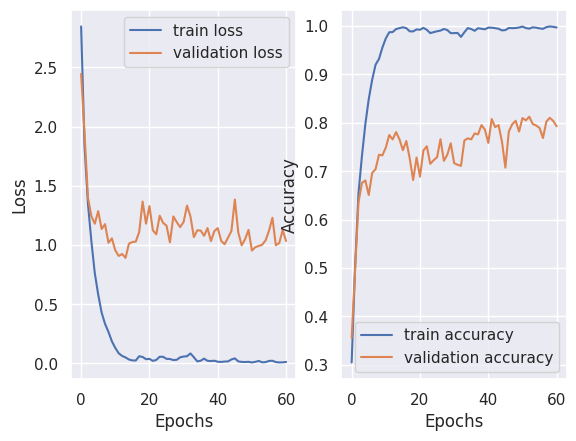

Train Loss: 0.0068, Acc: 0.99755859375

Val Loss: 1.0190, Acc: 0.803850457072258
Train Loss: 0.0054, Acc: 0.997151693329215

Val Loss: 1.0420, Acc: 0.8094308078289032
Train Loss: 0.0067, Acc: 0.998291015625

Val Loss: 1.0984, Acc: 0.797991082072258
Train Loss: 0.0028, Acc: 0.999755859375

Val Loss: 1.1186, Acc: 0.8007812649011612
Train Loss: 0.0023, Acc: 0.999755859375

Val Loss: 1.0889, Acc: 0.8063616156578064
Train Loss: 0.0079, Acc: 0.9972330741584301

Val Loss: 1.0617, Acc: 0.7988281399011612
Train Loss: 0.0201, Acc: 0.993245443329215

Val Loss: 1.2588, Acc: 0.7779017984867096
Train Loss: 0.0254, Acc: 0.9931640625

Val Loss: 1.1485, Acc: 0.7712053656578064
Train Loss: 0.0211, Acc: 0.995849609375

Val Loss: 1.1360, Acc: 0.7815290242433548
Train Loss: 0.0088, Acc: 0.997802734375

Val Loss: 1.1190, Acc: 0.7985491156578064
Train Loss: 0.0106, Acc: 0.9969889335334301

Val Loss: 1.0510, Acc: 0.8102678656578064
Train Loss: 0.0332, Acc: 0.991048177704215

Val Loss: 1.1880, Acc: 0.794084832

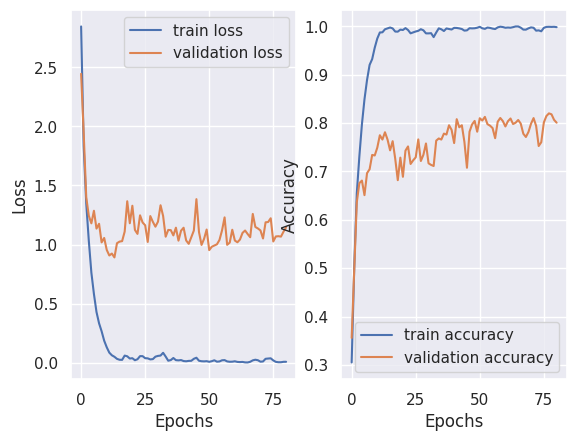

Train Loss: 0.0100, Acc: 0.996907552704215

Val Loss: 1.1342, Acc: 0.8069196492433548
Train Loss: 0.0422, Acc: 0.98779296875

Val Loss: 1.2086, Acc: 0.7553013414144516
Train Loss: 0.0298, Acc: 0.99267578125

Val Loss: 1.2614, Acc: 0.7474888414144516
Train Loss: 0.0232, Acc: 0.9947916679084301

Val Loss: 1.1697, Acc: 0.7812500149011612
Train Loss: 0.0290, Acc: 0.9911295585334301

Val Loss: 1.2290, Acc: 0.7541852742433548
Train Loss: 0.0203, Acc: 0.9935709647834301

Val Loss: 1.2424, Acc: 0.7700892984867096
Train Loss: 0.0147, Acc: 0.995361328125

Val Loss: 1.2964, Acc: 0.756975457072258
Train Loss: 0.0113, Acc: 0.9960123710334301

Val Loss: 1.1651, Acc: 0.7812500149011612
Train Loss: 0.0127, Acc: 0.99609375

Val Loss: 1.1062, Acc: 0.786272332072258
Train Loss: 0.0231, Acc: 0.994222005829215

Val Loss: 1.1705, Acc: 0.790178582072258
Train Loss: 0.0297, Acc: 0.992431640625

Val Loss: 1.2294, Acc: 0.7656250149011612
Train Loss: 0.0126, Acc: 0.996826171875

Val Loss: 1.2030, Acc: 0.78766742

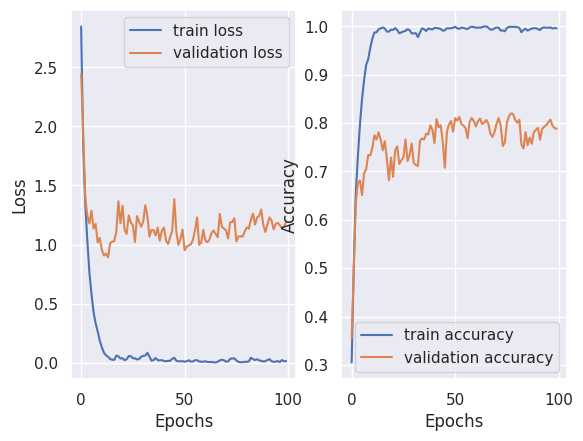

In [24]:
nir_net, _ = train_resnet(train_dataset_nir, val_dataset_nir, 1e-4)

Processing epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Train Loss: 2.9117, Acc: 0.296630859375

Val Loss: 2.1234, Acc: 0.4062500074505806
Train Loss: 1.8719, Acc: 0.49031575582921505

Val Loss: 1.7062, Acc: 0.5577566996216774
Train Loss: 1.3680, Acc: 0.642659505829215

Val Loss: 1.4359, Acc: 0.63671875
Train Loss: 1.0318, Acc: 0.726399740204215

Val Loss: 1.3239, Acc: 0.6674107164144516
Train Loss: 0.7714, Acc: 0.799886068329215

Val Loss: 1.2271, Acc: 0.6743861734867096
Train Loss: 0.5813, Acc: 0.84814453125

Val Loss: 1.1824, Acc: 0.684709832072258
Train Loss: 0.4411, Acc: 0.887939453125

Val Loss: 1.1106, Acc: 0.7151227742433548
Train Loss: 0.3343, Acc: 0.9191080741584301

Val Loss: 1.1322, Acc: 0.7067522406578064
Train Loss: 0.2487, Acc: 0.945149740204215

Val Loss: 1.2407, Acc: 0.6849888414144516
Train Loss: 0.1954, Acc: 0.9601236991584301

Val Loss: 1.2159, Acc: 0.6953125149011612
Train Loss: 0.1475, Acc: 0.97314453125

Val Loss: 1.1495, Acc: 0.7318638414144516
Train Loss: 0.1032, Acc: 0.983154296875

Val Loss: 1.1697, Acc: 0.7237723

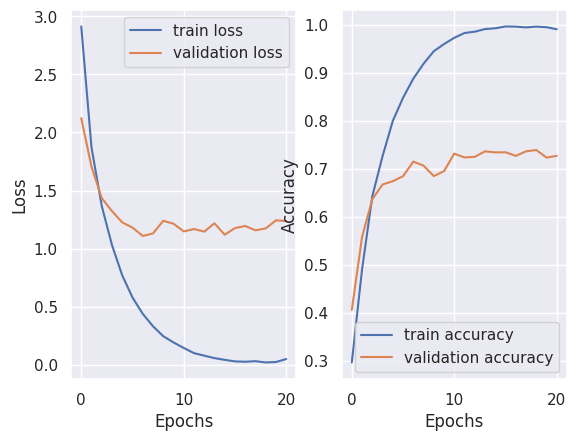

Train Loss: 0.0491, Acc: 0.990559896454215

Val Loss: 1.1951, Acc: 0.7265625149011612
Train Loss: 0.0396, Acc: 0.9912109375

Val Loss: 1.2205, Acc: 0.7352120578289032
Train Loss: 0.0290, Acc: 0.996337890625

Val Loss: 1.2405, Acc: 0.7324218899011612
Train Loss: 0.0110, Acc: 0.998779296875

Val Loss: 1.2104, Acc: 0.7360491156578064
Train Loss: 0.0071, Acc: 0.999755859375

Val Loss: 1.1665, Acc: 0.747209832072258
Train Loss: 0.0169, Acc: 0.996175130829215

Val Loss: 1.1788, Acc: 0.743303582072258
Train Loss: 0.0166, Acc: 0.996337890625

Val Loss: 1.2395, Acc: 0.7363281399011612
Train Loss: 0.0213, Acc: 0.995442708954215

Val Loss: 1.2662, Acc: 0.7446986734867096
Train Loss: 0.0393, Acc: 0.990559896454215

Val Loss: 1.2937, Acc: 0.7318638414144516
Train Loss: 0.0429, Acc: 0.9911295585334301

Val Loss: 1.2746, Acc: 0.7290736734867096
Train Loss: 0.0638, Acc: 0.985432943329215

Val Loss: 1.4170, Acc: 0.7106584906578064
Train Loss: 0.0504, Acc: 0.985677083954215

Val Loss: 1.4040, Acc: 0.712

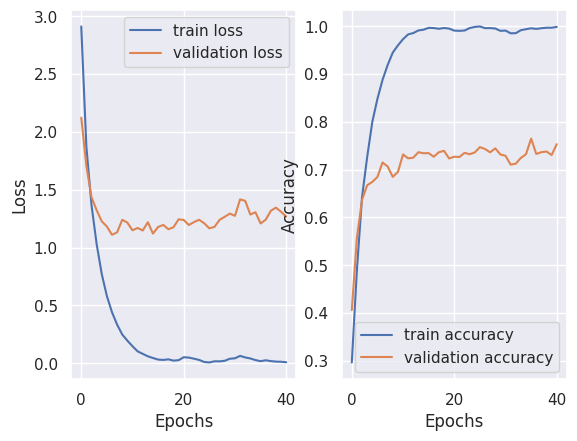

Train Loss: 0.0109, Acc: 0.9972330741584301

Val Loss: 1.2948, Acc: 0.7513950914144516
Train Loss: 0.0173, Acc: 0.996337890625

Val Loss: 1.3524, Acc: 0.7382812649011612
Train Loss: 0.0088, Acc: 0.99853515625

Val Loss: 1.2437, Acc: 0.7402343899011612
Train Loss: 0.0102, Acc: 0.998291015625

Val Loss: 1.3788, Acc: 0.715959832072258
Train Loss: 0.0201, Acc: 0.9947916679084301

Val Loss: 1.3367, Acc: 0.7444196492433548
Train Loss: 0.0380, Acc: 0.9901529960334301

Val Loss: 1.3629, Acc: 0.7025669664144516
Train Loss: 0.0328, Acc: 0.9921061210334301

Val Loss: 1.4541, Acc: 0.7053571492433548
Train Loss: 0.0206, Acc: 0.9951171875

Val Loss: 1.3391, Acc: 0.7268415242433548
Train Loss: 0.0215, Acc: 0.994873046875

Val Loss: 1.2760, Acc: 0.7513950914144516
Train Loss: 0.0124, Acc: 0.9967447929084301

Val Loss: 1.4503, Acc: 0.735491082072258
Train Loss: 0.0101, Acc: 0.997802734375

Val Loss: 1.3814, Acc: 0.7248883992433548
Train Loss: 0.0100, Acc: 0.998046875

Val Loss: 1.3462, Acc: 0.743861615

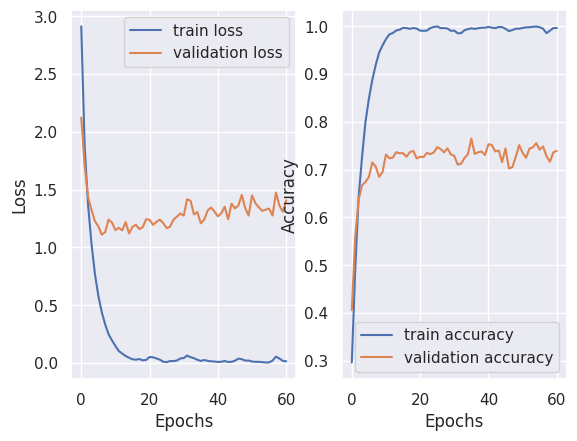

Train Loss: 0.0129, Acc: 0.99609375

Val Loss: 1.3580, Acc: 0.7564174234867096
Train Loss: 0.0103, Acc: 0.9967447929084301

Val Loss: 1.3505, Acc: 0.7460937649011612
Train Loss: 0.0157, Acc: 0.996826171875

Val Loss: 1.3223, Acc: 0.7396763414144516
Train Loss: 0.0229, Acc: 0.99072265625

Val Loss: 1.4435, Acc: 0.7363281399011612
Train Loss: 0.0480, Acc: 0.987630208954215

Val Loss: 1.4176, Acc: 0.7329799234867096
Train Loss: 0.0243, Acc: 0.9943033866584301

Val Loss: 1.2522, Acc: 0.7299107164144516
Train Loss: 0.0243, Acc: 0.993733724579215

Val Loss: 1.3816, Acc: 0.7606026828289032
Train Loss: 0.0325, Acc: 0.9894205741584301

Val Loss: 1.3518, Acc: 0.7340959906578064
Train Loss: 0.0299, Acc: 0.9945475272834301

Val Loss: 1.2751, Acc: 0.7522321492433548
Train Loss: 0.0146, Acc: 0.99609375

Val Loss: 1.3563, Acc: 0.7606026828289032
Train Loss: 0.0060, Acc: 0.998779296875

Val Loss: 1.3564, Acc: 0.7449776828289032
Train Loss: 0.0038, Acc: 0.99951171875

Val Loss: 1.3924, Acc: 0.740234389

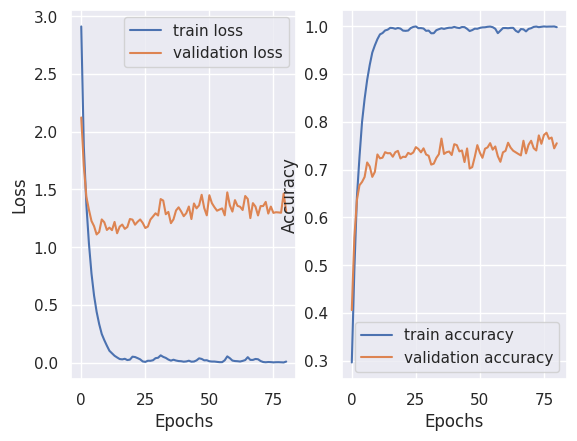

Train Loss: 0.0100, Acc: 0.996175130829215

Val Loss: 1.3382, Acc: 0.7639508992433548
Train Loss: 0.0130, Acc: 0.9957682304084301

Val Loss: 1.3097, Acc: 0.7349330484867096
Train Loss: 0.0122, Acc: 0.9960123710334301

Val Loss: 1.3644, Acc: 0.7405133992433548
Train Loss: 0.0179, Acc: 0.995849609375

Val Loss: 1.3579, Acc: 0.7458147406578064
Train Loss: 0.0115, Acc: 0.997314453125

Val Loss: 1.3605, Acc: 0.7446986734867096
Train Loss: 0.0054, Acc: 0.9990234375

Val Loss: 1.4957, Acc: 0.7318638414144516
Train Loss: 0.0111, Acc: 0.99755859375

Val Loss: 1.3547, Acc: 0.7360491156578064
Train Loss: 0.0067, Acc: 0.9974772147834301

Val Loss: 1.4546, Acc: 0.729631707072258
Train Loss: 0.0158, Acc: 0.9957682304084301

Val Loss: 1.4218, Acc: 0.7460937649011612
Train Loss: 0.0352, Acc: 0.992431640625

Val Loss: 1.3626, Acc: 0.7279575914144516
Train Loss: 0.0539, Acc: 0.987060546875

Val Loss: 1.3904, Acc: 0.6994977742433548
Train Loss: 0.0276, Acc: 0.99462890625

Val Loss: 1.4624, Acc: 0.7435825

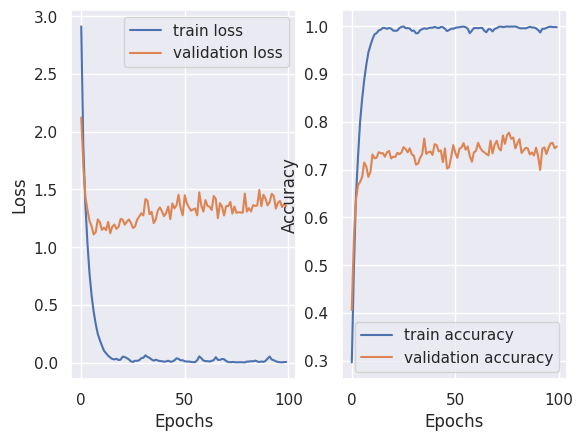

In [25]:
cycle_gan_net, _ = train_resnet(train_dataset_cycle_gan, val_dataset_cycle_gan, 1e-4)

Processing epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Train Loss: 2.8965, Acc: 0.29036458395421505

Val Loss: 2.2464, Acc: 0.3984375074505806
Train Loss: 1.8423, Acc: 0.5004069013521075

Val Loss: 1.8514, Acc: 0.4799107164144516
Train Loss: 1.3532, Acc: 0.636962890625

Val Loss: 1.6699, Acc: 0.5465959906578064
Train Loss: 0.9938, Acc: 0.746175130829215

Val Loss: 1.6199, Acc: 0.567522332072258
Train Loss: 0.7244, Acc: 0.812744140625

Val Loss: 1.5190, Acc: 0.5993303656578064
Train Loss: 0.5318, Acc: 0.865478515625

Val Loss: 1.4422, Acc: 0.6169084906578064
Train Loss: 0.3962, Acc: 0.903889974579215

Val Loss: 1.5260, Acc: 0.6018415242433548
Train Loss: 0.2769, Acc: 0.9375

Val Loss: 1.4416, Acc: 0.6157924234867096
Train Loss: 0.2008, Acc: 0.9545084647834301

Val Loss: 1.5019, Acc: 0.625
Train Loss: 0.1565, Acc: 0.967122396454215

Val Loss: 1.3982, Acc: 0.641741082072258
Train Loss: 0.1247, Acc: 0.9794921875

Val Loss: 1.5241, Acc: 0.6255580484867096
Train Loss: 0.0871, Acc: 0.9877115897834301

Val Loss: 1.4720, Acc: 0.6194196492433548
Tra

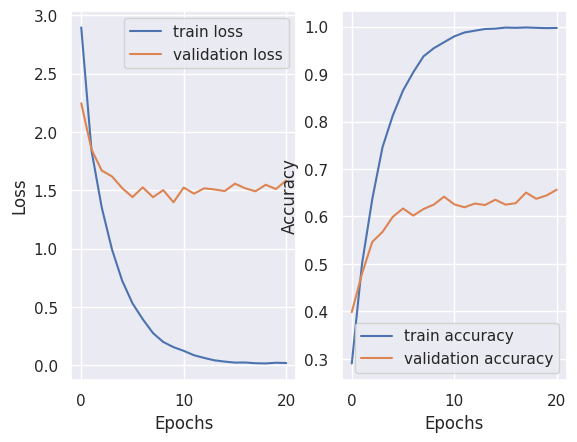

Train Loss: 0.0316, Acc: 0.992757162079215

Val Loss: 1.5605, Acc: 0.6350446492433548
Train Loss: 0.0283, Acc: 0.9945475272834301

Val Loss: 1.5679, Acc: 0.66015625
Train Loss: 0.0259, Acc: 0.9947916679084301

Val Loss: 1.6165, Acc: 0.6498325914144516
Train Loss: 0.0331, Acc: 0.993896484375

Val Loss: 1.8327, Acc: 0.6171875
Train Loss: 0.0366, Acc: 0.9906412772834301

Val Loss: 1.6919, Acc: 0.638671875
Train Loss: 0.0398, Acc: 0.991943359375

Val Loss: 1.5297, Acc: 0.639787957072258
Train Loss: 0.0286, Acc: 0.99560546875

Val Loss: 1.7168, Acc: 0.623046875
Train Loss: 0.0336, Acc: 0.9928385429084301

Val Loss: 1.5642, Acc: 0.6473214328289032
Train Loss: 0.0294, Acc: 0.993896484375

Val Loss: 1.6502, Acc: 0.6646205484867096
Train Loss: 0.0297, Acc: 0.9950358085334301

Val Loss: 1.6539, Acc: 0.6434151828289032
Train Loss: 0.0273, Acc: 0.99560546875

Val Loss: 1.7003, Acc: 0.650390625
Train Loss: 0.0117, Acc: 0.998291015625

Val Loss: 1.6889, Acc: 0.6364397406578064
Train Loss: 0.0128, Ac

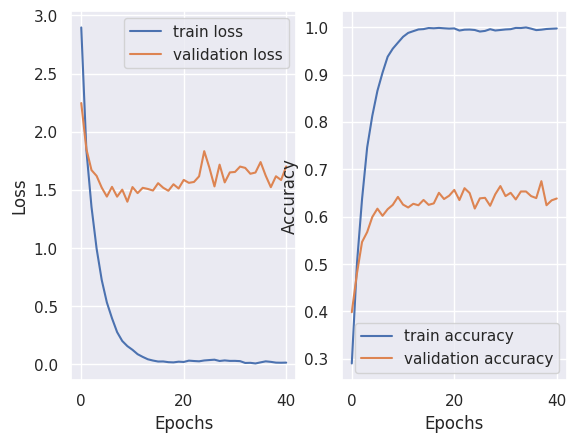

Train Loss: 0.0174, Acc: 0.996337890625

Val Loss: 1.7326, Acc: 0.6258370578289032
Train Loss: 0.0170, Acc: 0.9965006522834301

Val Loss: 1.6924, Acc: 0.634765625
Train Loss: 0.0264, Acc: 0.9951171875

Val Loss: 1.7052, Acc: 0.643694207072258
Train Loss: 0.0147, Acc: 0.9952799491584301

Val Loss: 1.7801, Acc: 0.6395089328289032
Train Loss: 0.0279, Acc: 0.992919921875

Val Loss: 1.6197, Acc: 0.6453683078289032
Train Loss: 0.0173, Acc: 0.996337890625

Val Loss: 1.7125, Acc: 0.6227678656578064
Train Loss: 0.0165, Acc: 0.994466146454215

Val Loss: 1.5753, Acc: 0.6637834906578064
Train Loss: 0.0248, Acc: 0.993489583954215

Val Loss: 1.5834, Acc: 0.6584821492433548
Train Loss: 0.0345, Acc: 0.992431640625

Val Loss: 1.6505, Acc: 0.6556919664144516
Train Loss: 0.0195, Acc: 0.995849609375

Val Loss: 1.6056, Acc: 0.653459832072258
Train Loss: 0.0094, Acc: 0.998046875

Val Loss: 1.6320, Acc: 0.6489955484867096
Train Loss: 0.0135, Acc: 0.9979654960334301

Val Loss: 1.6508, Acc: 0.6556919664144516


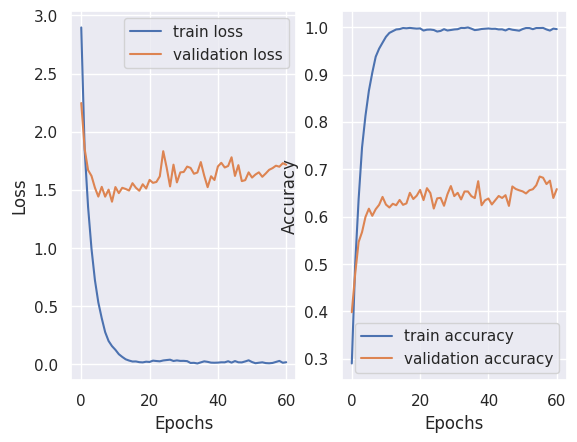

Train Loss: 0.0159, Acc: 0.996826171875

Val Loss: 1.7589, Acc: 0.6462053656578064
Train Loss: 0.0110, Acc: 0.997802734375

Val Loss: 1.7786, Acc: 0.6548549234867096
Train Loss: 0.0075, Acc: 0.9974772147834301

Val Loss: 1.7461, Acc: 0.6732700914144516
Train Loss: 0.0145, Acc: 0.9962565116584301

Val Loss: 1.8455, Acc: 0.64453125
Train Loss: 0.0166, Acc: 0.99560546875

Val Loss: 1.7718, Acc: 0.6489955484867096
Train Loss: 0.0095, Acc: 0.998046875

Val Loss: 1.8474, Acc: 0.6450892984867096
Train Loss: 0.0097, Acc: 0.9977213554084301

Val Loss: 1.7337, Acc: 0.6646205484867096
Train Loss: 0.0149, Acc: 0.99658203125

Val Loss: 1.8255, Acc: 0.6556919664144516
Train Loss: 0.0151, Acc: 0.9967447929084301

Val Loss: 1.7585, Acc: 0.6587611734867096
Train Loss: 0.0198, Acc: 0.994873046875

Val Loss: 1.8002, Acc: 0.6467633992433548
Train Loss: 0.0172, Acc: 0.995849609375

Val Loss: 1.6579, Acc: 0.667131707072258
Train Loss: 0.0166, Acc: 0.99658203125

Val Loss: 1.6455, Acc: 0.6579241156578064
Tra

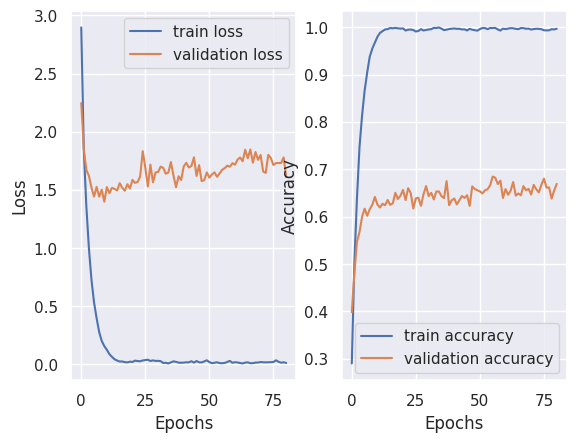

Train Loss: 0.0145, Acc: 0.9967447929084301

Val Loss: 1.7311, Acc: 0.6662946492433548
Train Loss: 0.0212, Acc: 0.9952799491584301

Val Loss: 1.8084, Acc: 0.6598772406578064
Train Loss: 0.0209, Acc: 0.99560546875

Val Loss: 1.8167, Acc: 0.667131707072258
Train Loss: 0.0107, Acc: 0.99755859375

Val Loss: 1.6757, Acc: 0.6771763414144516
Train Loss: 0.0079, Acc: 0.9972330741584301

Val Loss: 1.7152, Acc: 0.667131707072258
Train Loss: 0.0124, Acc: 0.9950358085334301

Val Loss: 1.6985, Acc: 0.68359375
Train Loss: 0.0148, Acc: 0.9970703125

Val Loss: 1.6230, Acc: 0.6908482164144516
Train Loss: 0.0093, Acc: 0.99853515625

Val Loss: 1.6869, Acc: 0.6766183078289032
Train Loss: 0.0122, Acc: 0.9974772147834301

Val Loss: 1.7841, Acc: 0.657366082072258
Train Loss: 0.0211, Acc: 0.99609375

Val Loss: 1.6629, Acc: 0.6598772406578064
Train Loss: 0.0279, Acc: 0.9931640625

Val Loss: 1.8308, Acc: 0.6420200914144516
Train Loss: 0.0146, Acc: 0.995849609375

Val Loss: 1.6515, Acc: 0.692522332072258
Train L

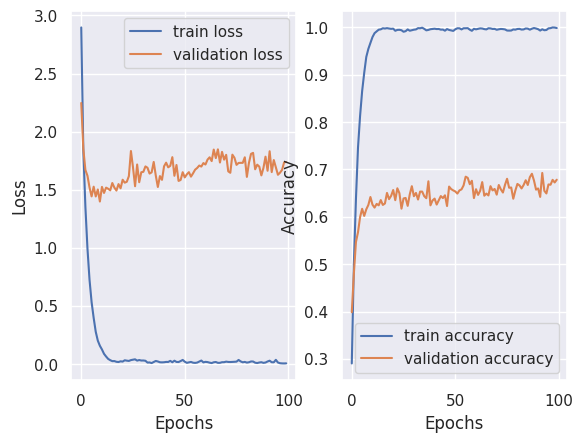

In [26]:
iis_net, _ = train_resnet(train_dataset_iis, val_dataset_iis, 1e-4)

Processing epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Train Loss: 2.9546, Acc: 0.27351888082921505

Val Loss: 2.2396, Acc: 0.3811383992433548
Train Loss: 1.9816, Acc: 0.46077474020421505

Val Loss: 1.8490, Acc: 0.531808041036129
Train Loss: 1.5214, Acc: 0.589436849579215

Val Loss: 1.6260, Acc: 0.5828683078289032
Train Loss: 1.1610, Acc: 0.692626953125

Val Loss: 1.4628, Acc: 0.6040736734867096
Train Loss: 0.8671, Acc: 0.7763671875

Val Loss: 1.3781, Acc: 0.641741082072258
Train Loss: 0.6544, Acc: 0.837890625

Val Loss: 1.2861, Acc: 0.6587611734867096
Train Loss: 0.4910, Acc: 0.875

Val Loss: 1.2874, Acc: 0.6609933078289032
Train Loss: 0.3429, Acc: 0.922119140625

Val Loss: 1.2308, Acc: 0.6598772406578064
Train Loss: 0.2448, Acc: 0.947998046875

Val Loss: 1.2978, Acc: 0.6724330484867096
Train Loss: 0.1954, Acc: 0.9601236991584301

Val Loss: 1.2774, Acc: 0.682756707072258
Train Loss: 0.1368, Acc: 0.976806640625

Val Loss: 1.2706, Acc: 0.6821986734867096
Train Loss: 0.1065, Acc: 0.982177734375

Val Loss: 1.3869, Acc: 0.6791294664144516
Trai

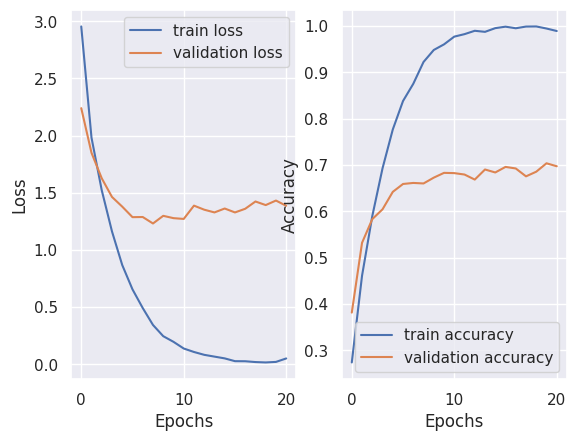

Train Loss: 0.0306, Acc: 0.994384765625

Val Loss: 1.3643, Acc: 0.6821986734867096
Train Loss: 0.0195, Acc: 0.99755859375

Val Loss: 1.4490, Acc: 0.6939174234867096
Train Loss: 0.0145, Acc: 0.99853515625

Val Loss: 1.3996, Acc: 0.6813616156578064
Train Loss: 0.0141, Acc: 0.998779296875

Val Loss: 1.4444, Acc: 0.704241082072258
Train Loss: 0.0154, Acc: 0.9960123710334301

Val Loss: 1.4179, Acc: 0.698381707072258
Train Loss: 0.0214, Acc: 0.994710287079215

Val Loss: 1.4688, Acc: 0.6875
Train Loss: 0.0319, Acc: 0.9933268241584301

Val Loss: 1.4705, Acc: 0.6819196492433548
Train Loss: 0.0261, Acc: 0.9928385429084301

Val Loss: 1.3677, Acc: 0.698381707072258
Train Loss: 0.0323, Acc: 0.9925944022834301

Val Loss: 1.4970, Acc: 0.6763392984867096
Train Loss: 0.0334, Acc: 0.9935709647834301

Val Loss: 1.5529, Acc: 0.6771763414144516
Train Loss: 0.0532, Acc: 0.985921224579215

Val Loss: 1.5564, Acc: 0.6702008992433548
Train Loss: 0.0433, Acc: 0.9874674491584301

Val Loss: 1.4749, Acc: 0.67773437

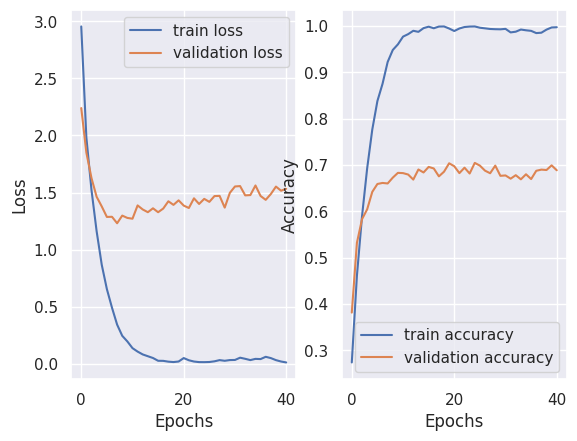

Train Loss: 0.0106, Acc: 0.9972330741584301

Val Loss: 1.4688, Acc: 0.6902901828289032
Train Loss: 0.0108, Acc: 0.998291015625

Val Loss: 1.5904, Acc: 0.6838727742433548
Train Loss: 0.0062, Acc: 0.9990234375

Val Loss: 1.5463, Acc: 0.710100457072258
Train Loss: 0.0067, Acc: 0.9990234375

Val Loss: 1.5065, Acc: 0.7095424234867096
Train Loss: 0.0078, Acc: 0.996907552704215

Val Loss: 1.4123, Acc: 0.727678582072258
Train Loss: 0.0178, Acc: 0.995361328125

Val Loss: 1.5837, Acc: 0.6852678656578064
Train Loss: 0.0158, Acc: 0.9960123710334301

Val Loss: 1.4651, Acc: 0.6916852742433548
Train Loss: 0.0148, Acc: 0.9960123710334301

Val Loss: 1.4088, Acc: 0.7193080484867096
Train Loss: 0.0159, Acc: 0.99658203125

Val Loss: 1.4821, Acc: 0.7008928656578064
Train Loss: 0.0085, Acc: 0.998046875

Val Loss: 1.4815, Acc: 0.690569207072258
Train Loss: 0.0031, Acc: 0.999755859375

Val Loss: 1.4069, Acc: 0.7254464328289032
Train Loss: 0.0039, Acc: 0.9984537772834301

Val Loss: 1.5113, Acc: 0.7045200914144

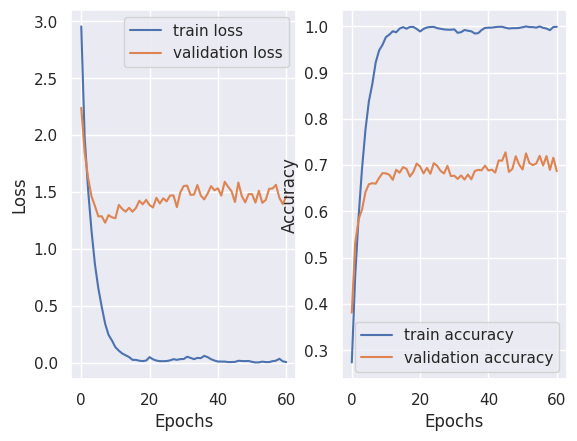

Train Loss: 0.0120, Acc: 0.9979654960334301

Val Loss: 1.5226, Acc: 0.6911272406578064
Train Loss: 0.0180, Acc: 0.995849609375

Val Loss: 1.5427, Acc: 0.701171875
Train Loss: 0.0163, Acc: 0.9970703125

Val Loss: 1.5114, Acc: 0.7092633992433548
Train Loss: 0.0099, Acc: 0.997802734375

Val Loss: 1.4885, Acc: 0.6911272406578064
Train Loss: 0.0141, Acc: 0.994954427704215

Val Loss: 1.5070, Acc: 0.692522332072258
Train Loss: 0.0293, Acc: 0.992431640625

Val Loss: 1.4963, Acc: 0.6875
Train Loss: 0.0215, Acc: 0.9957682304084301

Val Loss: 1.5582, Acc: 0.6908482164144516
Train Loss: 0.0133, Acc: 0.997314453125

Val Loss: 1.5707, Acc: 0.7126116156578064
Train Loss: 0.0130, Acc: 0.9974772147834301

Val Loss: 1.5804, Acc: 0.701171875
Train Loss: 0.0161, Acc: 0.9955240897834301

Val Loss: 1.6557, Acc: 0.697265625
Train Loss: 0.0108, Acc: 0.997314453125

Val Loss: 1.6782, Acc: 0.6872209906578064
Train Loss: 0.0090, Acc: 0.9972330741584301

Val Loss: 1.7079, Acc: 0.689453125
Train Loss: 0.0158, Acc:

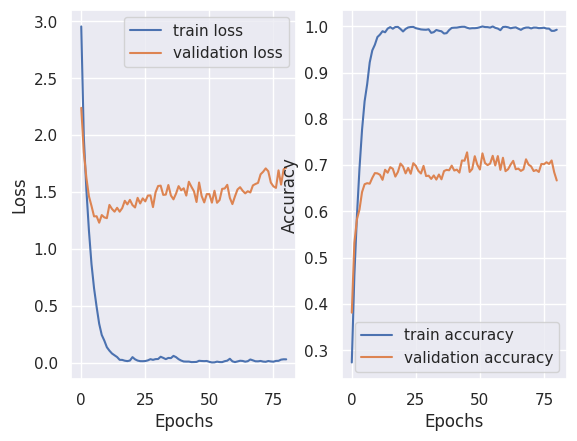

Train Loss: 0.0274, Acc: 0.990804037079215

Val Loss: 1.6273, Acc: 0.6967075914144516
Train Loss: 0.0383, Acc: 0.989501953125

Val Loss: 1.5774, Acc: 0.6958705484867096
Train Loss: 0.0244, Acc: 0.993896484375

Val Loss: 1.6236, Acc: 0.7078683078289032
Train Loss: 0.0068, Acc: 0.998291015625

Val Loss: 1.5746, Acc: 0.6981026828289032
Train Loss: 0.0100, Acc: 0.998046875

Val Loss: 1.6080, Acc: 0.6975446492433548
Train Loss: 0.0080, Acc: 0.9977213554084301

Val Loss: 1.6443, Acc: 0.69921875
Train Loss: 0.0139, Acc: 0.996337890625

Val Loss: 1.7277, Acc: 0.6704799234867096
Train Loss: 0.0071, Acc: 0.9990234375

Val Loss: 1.7421, Acc: 0.6919642984867096
Train Loss: 0.0048, Acc: 0.99951171875

Val Loss: 1.5969, Acc: 0.72265625
Train Loss: 0.0046, Acc: 0.9982096366584301

Val Loss: 1.5973, Acc: 0.7006138414144516
Train Loss: 0.0089, Acc: 0.998046875

Val Loss: 1.6755, Acc: 0.721819207072258
Train Loss: 0.0034, Acc: 0.999267578125

Val Loss: 1.6500, Acc: 0.7028459906578064
Train Loss: 0.0024,

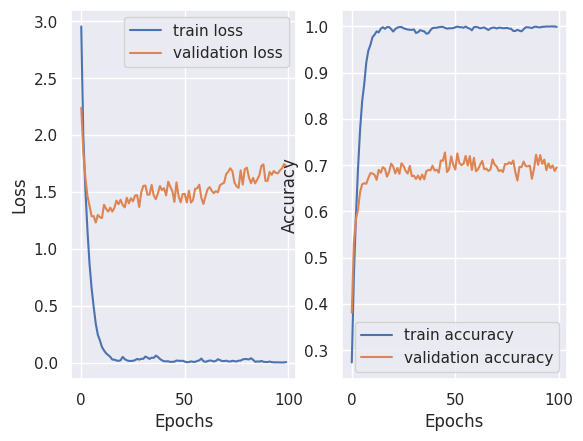

In [27]:
ihfs_net, _ = train_resnet(train_dataset_ihfs, val_dataset_ihfs, 1e-4)

Processing epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Train Loss: 2.9276, Acc: 0.27978515625

Val Loss: 2.2014, Acc: 0.4182477742433548
Train Loss: 1.9154, Acc: 0.4740397138521075

Val Loss: 1.7595, Acc: 0.5549665242433548
Train Loss: 1.4188, Acc: 0.614827474579215

Val Loss: 1.5579, Acc: 0.6177455484867096
Train Loss: 1.0713, Acc: 0.7186686210334301

Val Loss: 1.4230, Acc: 0.626953125
Train Loss: 0.8074, Acc: 0.782958984375

Val Loss: 1.3340, Acc: 0.6462053656578064
Train Loss: 0.6057, Acc: 0.8444010429084301

Val Loss: 1.2963, Acc: 0.6618303656578064
Train Loss: 0.4627, Acc: 0.884114583954215

Val Loss: 1.2393, Acc: 0.7011718899011612
Train Loss: 0.3365, Acc: 0.925537109375

Val Loss: 1.2469, Acc: 0.681640625
Train Loss: 0.2372, Acc: 0.9496256522834301

Val Loss: 1.2266, Acc: 0.7000558078289032
Train Loss: 0.1798, Acc: 0.960693359375

Val Loss: 1.1753, Acc: 0.7190290242433548
Train Loss: 0.1310, Acc: 0.979085287079215

Val Loss: 1.1739, Acc: 0.7017299234867096
Train Loss: 0.0916, Acc: 0.98828125

Val Loss: 1.2408, Acc: 0.702008932828903

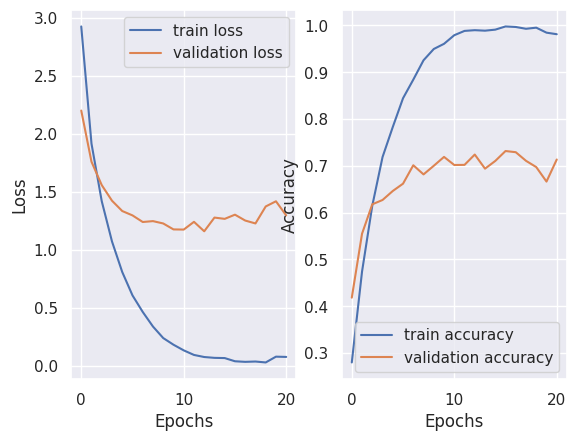

Train Loss: 0.0566, Acc: 0.988362630829215

Val Loss: 1.3327, Acc: 0.7014508992433548
Train Loss: 0.0332, Acc: 0.994873046875

Val Loss: 1.2283, Acc: 0.7307477742433548
Train Loss: 0.0179, Acc: 0.9970703125

Val Loss: 1.2681, Acc: 0.7502790242433548
Train Loss: 0.0124, Acc: 0.998046875

Val Loss: 1.2923, Acc: 0.7176339328289032
Train Loss: 0.0110, Acc: 0.99853515625

Val Loss: 1.3324, Acc: 0.727678582072258
Train Loss: 0.0155, Acc: 0.995361328125

Val Loss: 1.3408, Acc: 0.7391183078289032
Train Loss: 0.0247, Acc: 0.994140625

Val Loss: 1.3110, Acc: 0.7181919664144516
Train Loss: 0.0163, Acc: 0.99755859375

Val Loss: 1.2589, Acc: 0.7444196492433548
Train Loss: 0.0068, Acc: 0.999755859375

Val Loss: 1.2243, Acc: 0.7396763414144516
Train Loss: 0.0039, Acc: 0.999755859375

Val Loss: 1.3460, Acc: 0.7435825914144516
Train Loss: 0.0090, Acc: 0.995849609375

Val Loss: 1.2581, Acc: 0.7500000149011612
Train Loss: 0.0199, Acc: 0.996826171875

Val Loss: 1.3544, Acc: 0.7287946492433548
Train Loss: 

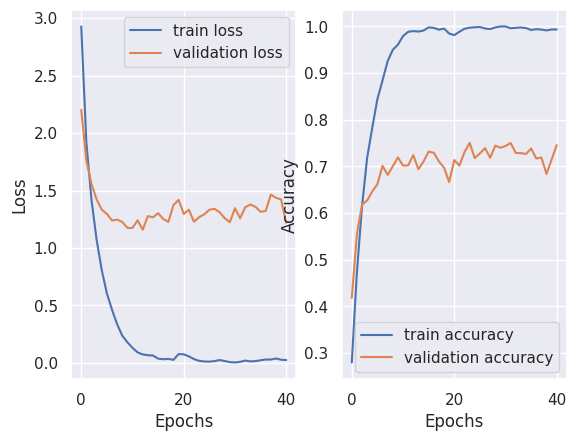

Train Loss: 0.0233, Acc: 0.9945475272834301

Val Loss: 1.3858, Acc: 0.7262834906578064
Train Loss: 0.0303, Acc: 0.9933268241584301

Val Loss: 1.3099, Acc: 0.725725457072258
Train Loss: 0.0232, Acc: 0.994873046875

Val Loss: 1.3017, Acc: 0.7207031399011612
Train Loss: 0.0191, Acc: 0.9957682304084301

Val Loss: 1.2830, Acc: 0.7173549234867096
Train Loss: 0.0159, Acc: 0.9962565116584301

Val Loss: 1.3704, Acc: 0.7287946492433548
Train Loss: 0.0271, Acc: 0.9925944022834301

Val Loss: 1.5012, Acc: 0.6841517984867096
Train Loss: 0.0256, Acc: 0.994384765625

Val Loss: 1.4260, Acc: 0.7025669664144516
Train Loss: 0.0147, Acc: 0.995849609375

Val Loss: 1.4316, Acc: 0.7148437649011612
Train Loss: 0.0113, Acc: 0.9967447929084301

Val Loss: 1.4127, Acc: 0.7366071492433548
Train Loss: 0.0158, Acc: 0.99560546875

Val Loss: 1.4561, Acc: 0.7156808078289032
Train Loss: 0.0122, Acc: 0.998046875

Val Loss: 1.4152, Acc: 0.727678582072258
Train Loss: 0.0060, Acc: 0.999267578125

Val Loss: 1.3105, Acc: 0.744

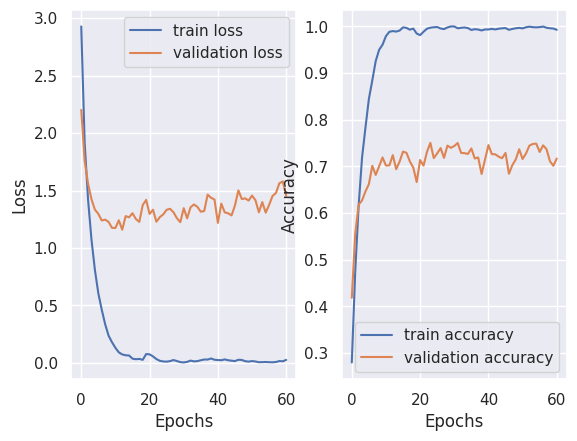

Train Loss: 0.0218, Acc: 0.994384765625

Val Loss: 1.4665, Acc: 0.7285156399011612
Train Loss: 0.0204, Acc: 0.9935709647834301

Val Loss: 1.4525, Acc: 0.7251674234867096
Train Loss: 0.0209, Acc: 0.994140625

Val Loss: 1.4417, Acc: 0.7265625149011612
Train Loss: 0.0145, Acc: 0.996337890625

Val Loss: 1.5226, Acc: 0.7190290242433548
Train Loss: 0.0123, Acc: 0.9957682304084301

Val Loss: 1.5112, Acc: 0.7165178656578064
Train Loss: 0.0239, Acc: 0.994140625

Val Loss: 1.4090, Acc: 0.7220982164144516
Train Loss: 0.0290, Acc: 0.992513021454215

Val Loss: 1.4623, Acc: 0.7137276828289032
Train Loss: 0.0342, Acc: 0.9912109375

Val Loss: 1.4123, Acc: 0.7008928656578064
Train Loss: 0.0300, Acc: 0.9923502616584301

Val Loss: 1.3082, Acc: 0.7385602742433548
Train Loss: 0.0196, Acc: 0.994140625

Val Loss: 1.3617, Acc: 0.7287946492433548
Train Loss: 0.0133, Acc: 0.99658203125

Val Loss: 1.4298, Acc: 0.735491082072258
Train Loss: 0.0115, Acc: 0.997314453125

Val Loss: 1.3803, Acc: 0.7357700914144516
Tr

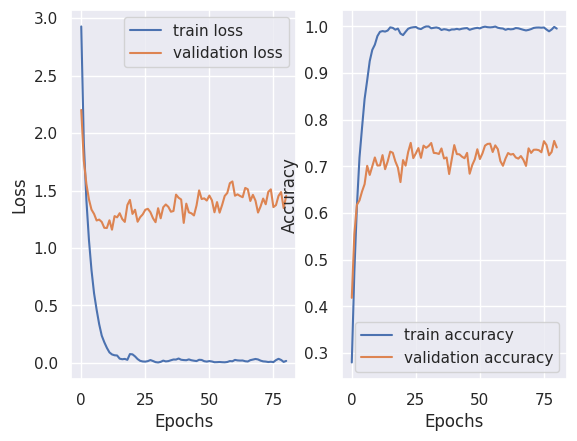

Train Loss: 0.0208, Acc: 0.9951171875

Val Loss: 1.4294, Acc: 0.7195870578289032
Train Loss: 0.0260, Acc: 0.993408203125

Val Loss: 1.5383, Acc: 0.6975446492433548
Train Loss: 0.0111, Acc: 0.9970703125

Val Loss: 1.4482, Acc: 0.6941964328289032
Train Loss: 0.0106, Acc: 0.9974772147834301

Val Loss: 1.4901, Acc: 0.7349330484867096
Train Loss: 0.0062, Acc: 0.9990234375

Val Loss: 1.4388, Acc: 0.733537957072258
Train Loss: 0.0018, Acc: 1.0

Val Loss: 1.3895, Acc: 0.7391183078289032
Train Loss: 0.0016, Acc: 0.999755859375

Val Loss: 1.4341, Acc: 0.7388392984867096
Train Loss: 0.0025, Acc: 0.99951171875

Val Loss: 1.4418, Acc: 0.7299107164144516
Train Loss: 0.0020, Acc: 0.99951171875

Val Loss: 1.4484, Acc: 0.729631707072258
Train Loss: 0.0047, Acc: 0.9986979179084301

Val Loss: 1.4621, Acc: 0.733537957072258
Train Loss: 0.0158, Acc: 0.99658203125

Val Loss: 1.5591, Acc: 0.7151227742433548
Train Loss: 0.0110, Acc: 0.998291015625

Val Loss: 1.4628, Acc: 0.7402343899011612
Train Loss: 0.0076,

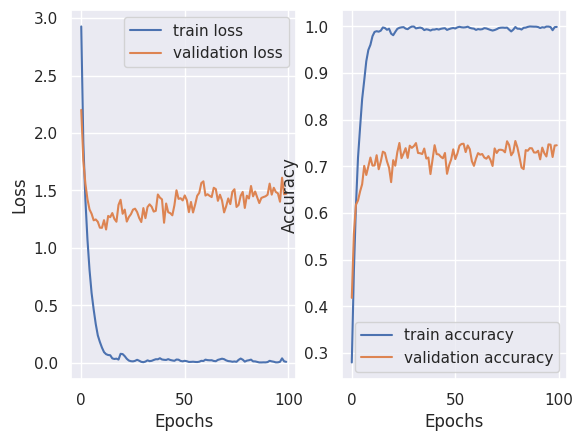

In [28]:
iis_cycle_gan_net, _ = train_resnet(train_dataset_iis_cycle_gan, val_dataset_iis_cycle_gan, 1e-4)

In [29]:
def test(model, test_loader, show_images=20):
    model.eval()

    running_acc = 0
    total = 0
    showed = 1
    with torch.no_grad():
        for counter, data in enumerate(test_loader):
            image, target = data['image'].to(device), data['label']
            outputs = model(image).detach().cpu()
            acc = accuracy(outputs, target)

            _, pred = torch.max(torch.log_softmax(outputs, dim=1), dim=1)
            pred_as_string = str(pred.item())

            running_acc += acc

            if showed < show_images and len(pred.flatten()) > 0:
                image = image.squeeze(0)
                image = image.detach().cpu().numpy()
                image = np.transpose(image, (1, 2, 0))
                plt.imshow(image)
                plt.axis('off')

                indices = np.argwhere(target.flatten())
                indices_as_string = " ".join([str(label.item()) for label in indices.flatten()])

                plt.title(f"PREDICTED: {pred_as_string}\nACTUAL: {indices_as_string}")
                plt.show()

                showed += 1

            total += 1

    return running_acc / total

In [30]:
test_dataset_rgb = SerengetiDataset(
    transform=validation_transformations,
    result=serengeti_night_large_rgb_test
)
test_dataset_nir = SerengetiDataset(
    transform=validation_transformations,
    result=serengeti_night_large_nir_test
)
test_dataset_iis = SerengetiDataset(
    transform=validation_transformations,
    result=iis_serengeti_night_large_test
)
test_dataset_cycle_gan = SerengetiDataset(
    transform=validation_transformations,
    result=cycle_gan_serengeti_night_large_test,
    file_name_corrector=lambda f: f.removesuffix("_fake")
)
test_dataset_ihfs = SerengetiDataset(
    transform=validation_transformations,
    result=ihfs_serengeti_night_large_test,
)
test_dataset_iis_cycle_gan = SerengetiDataset(
    transform=validation_transformations,
    result=iis_cycle_gan_serengeti_night_large_test,
    file_name_corrector=lambda f: f.removesuffix("_fake")
)

In [31]:
print("NIR", test(nir_net, DataLoader(test_dataset_nir, batch_size=1, shuffle=False), show_images=0))
print("CycleGAN",
      test(cycle_gan_net, DataLoader(test_dataset_cycle_gan, batch_size=1, shuffle=False), show_images=0))
print("IIS",
      test(iis_net, DataLoader(test_dataset_iis, batch_size=1, shuffle=False), show_images=0))
print("IHFS",
      test(ihfs_net, DataLoader(test_dataset_ihfs, batch_size=1, shuffle=False), show_images=0))
print("IIS CycleGAN",
      test(iis_cycle_gan_net, DataLoader(test_dataset_iis_cycle_gan, batch_size=1, shuffle=False), show_images=0))

NIR tensor(0.7490)
CycleGAN tensor(0.7129)
IIS tensor(0.7309)
IHFS tensor(0.6526)
IIS CycleGAN tensor(0.7108)
